In [1]:
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import category_encoders
from category_encoders.one_hot import OneHotEncoder
from category_encoders.cat_boost import CatBoostEncoder

from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import optuna
import warnings
warnings.filterwarnings("ignore")

In [2]:
TARGET_ENCODE = {"Relaxed":0,
                 "Focused":1,
                 "Anxious":2,
                 "Stressed":3
                }

TARGET_DECODE = {value:key for key,value in TARGET_ENCODE.items()}

SEED = 3126

In [3]:
data = pd.read_csv("/kaggle/input/psychological-state-identification-dataset/psychological_state_dataset.csv")

data.head()

,ID,Time,HRV (ms),GSR (μS),EEG Power Bands,Blood Pressure (mmHg),Oxygen Saturation (%),Heart Rate (BPM),Ambient Noise (dB),Cognitive Load,Mood State,Psychological State,Respiration Rate (BPM),Skin Temp (°C),Focus Duration (s),Task Type,Age,Gender,Educational Level,Study Major
0,1,2024-01-01 00:00:00,33.039739,1.031806,"[0.7583653347946298, 1.423247998317594, 0.6157...",114/79,98.433312,98,56.863054,Low,Anxious,Stressed,21,34.566484,27,Exam,22,Female,Postgraduate,Engineering
1,2,2024-01-01 00:00:01,49.914651,1.340983,"[0.5520419333516282, 1.858065835142619, 0.3766...",113/86,98.944505,70,45.343430,Low,Neutral,Stressed,21,35.358593,282,Assignment,23,Male,Undergraduate,Arts
2,3,2024-01-01 00:00:02,67.894401,1.006014,"[1.0261365005886114, 1.3504934190994182, 2.308...",124/74,95.990753,91,50.029264,High,Sad,Relaxed,17,34.359495,50,Group Discussion,18,Female,Postgraduate,Arts
3,4,2024-01-01 00:00:03,34.705373,0.849270,"[1.6075723109471591, 1.6619672129812242, 0.344...",120/73,98.173643,95,60.802104,Low,Neutral,Anxious,12,34.802638,223,Exam,28,Female,High School,Engineering
4,5,2024-01-01 00:00:04,52.896549,0.879084,"[1.055003922514022, 0.7643319894343756, 1.0745...",111/80,96.225051,65,40.696384,High,Anxious,Stressed,14,35.869862,201,Group Discussion,24,Female,High School,Engineering


In [4]:
## Drop features
data_clean = data.drop(columns=["ID", "Time", "Mood State"])

## Strip all parentheses; collapse all spaces
data_clean.columns = data_clean.columns.str.replace(r"\(.*", "", regex=True).str.replace(" ", "")

# Feature Engineering

In [5]:
data_clean["splitted_powerBands"] = data_clean.EEGPowerBands.str.split(", ")
data_clean["Dband_activity"] = data_clean.splitted_powerBands.apply(lambda value: float(value[0][1:8]))
data_clean["Aband_activity"] = data_clean.splitted_powerBands.apply(lambda value: float(value[1][0:7]))
data_clean["Bband_activity"] = data_clean.splitted_powerBands.apply(lambda value: float(value[2][0:7]))

data_clean["BP_topNum"] = data_clean.BloodPressure.apply(lambda value: float(value.split("/")[0]))
data_clean["BP_botNum"] = data_clean.BloodPressure.apply(lambda value: float(value.split("/")[1]))
data_clean["BP_ratio"] = data_clean["BP_topNum"]/data_clean["BP_botNum"]

data_clean.drop(columns=["EEGPowerBands", "splitted_powerBands", "BloodPressure"], inplace=True)

In [6]:
data_clean.head(5)

,HRV,GSR,OxygenSaturation,HeartRate,AmbientNoise,CognitiveLoad,PsychologicalState,RespirationRate,SkinTemp,FocusDuration,...,Age,Gender,EducationalLevel,StudyMajor,Dband_activity,Aband_activity,Bband_activity,BP_topNum,BP_botNum,BP_ratio
0,33.039739,1.031806,98.433312,98,56.863054,Low,Stressed,21,34.566484,27,...,22,Female,Postgraduate,Engineering,0.75836,1.42324,0.61576,114.0,79.0,1.443038
1,49.914651,1.340983,98.944505,70,45.343430,Low,Stressed,21,35.358593,282,...,23,Male,Undergraduate,Arts,0.55204,1.85806,0.37660,113.0,86.0,1.313953
2,67.894401,1.006014,95.990753,91,50.029264,High,Relaxed,17,34.359495,50,...,18,Female,Postgraduate,Arts,1.02613,1.35049,2.30876,124.0,74.0,1.675676
3,34.705373,0.849270,98.173643,95,60.802104,Low,Anxious,12,34.802638,223,...,28,Female,High School,Engineering,1.60757,1.66196,0.34413,120.0,73.0,1.643836
4,52.896549,0.879084,96.225051,65,40.696384,High,Stressed,14,35.869862,201,...,24,Female,High School,Engineering,1.05500,0.76433,1.07453,111.0,80.0,1.387500


In [7]:
X = data_clean.drop("PsychologicalState", axis=1)
y = data_clean.PsychologicalState.map(TARGET_ENCODE)

# CV function

In [8]:
def cv_validate(X, y, estimator, return_oof_val=True, n_splits=10):
    accuracy_scores = []
    ## Dict storing y_pred and y_val for each fold
    oof_and_val = {}
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    for iteration,(train_fold, val_fold) in enumerate(kfold.split(X)):
        X_train, y_train = X.loc[train_fold,:], y[train_fold]
        X_val,   y_val   = X.loc[val_fold,:],   y[val_fold]
        ## Trains and predicts using cloned estimator
        cloned_estimator = clone(estimator)
        cloned_estimator.fit(X_train, y_train)
        y_pred = cloned_estimator.predict(X_val)
        ## Store results
        oof_and_val[f"fold_{iteration+1}"] = {"y_pred":y_pred, 
                                              "y_val":y_val}
        accuracy = accuracy_score(y_val, y_pred)
        accuracy_scores.append(accuracy)

    if return_oof_val:
        return accuracy_scores, oof_and_val
    return accuracy_scores

# CatBoost
### 1. Using default catboost encoding results in higher mean cv score
### 2. Recall scores are consistently low for all classes (around 0.20)
### 3. Classes cannot be distinctly discriminated by the model, observed from confusion matrices in how no particular classes' recall scores are consistently high
### 4. Mean OOF accuracy score is 0.25

In [9]:
cat_features = X.select_dtypes(exclude="number").columns.tolist()

catboost_params1 = {"n_estimators":250,
                    "learning_rate":.045,
                    "max_depth":7,
                    "bagging_temperature":.5,
                    "loss_function":"MultiClass",
                    "random_state":SEED,
                    "thread_count":-1,
                    "verbose":0
                   }

catboost = CatBoostClassifier(**catboost_params1, cat_features=cat_features)
accuracy_scores, oof_and_val = cv_validate(X, y, catboost)

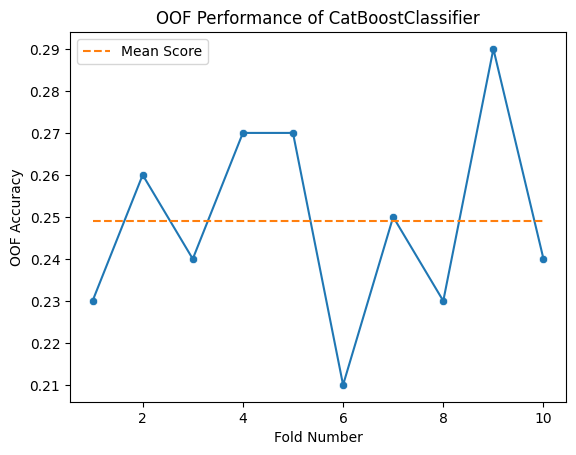

In [10]:
sea.scatterplot(x=np.arange(1, 11),
                y=accuracy_scores)
sea.lineplot(x=np.arange(1, 11),
             y=accuracy_scores)
sea.lineplot(x=np.arange(1, 11),
             y=np.mean(accuracy_scores),
             linestyle="dashed",
             label="Mean Score")

plt.xlabel("Fold Number")
plt.ylabel("OOF Accuracy")
plt.title("OOF Performance of CatBoostClassifier")
plt.show()

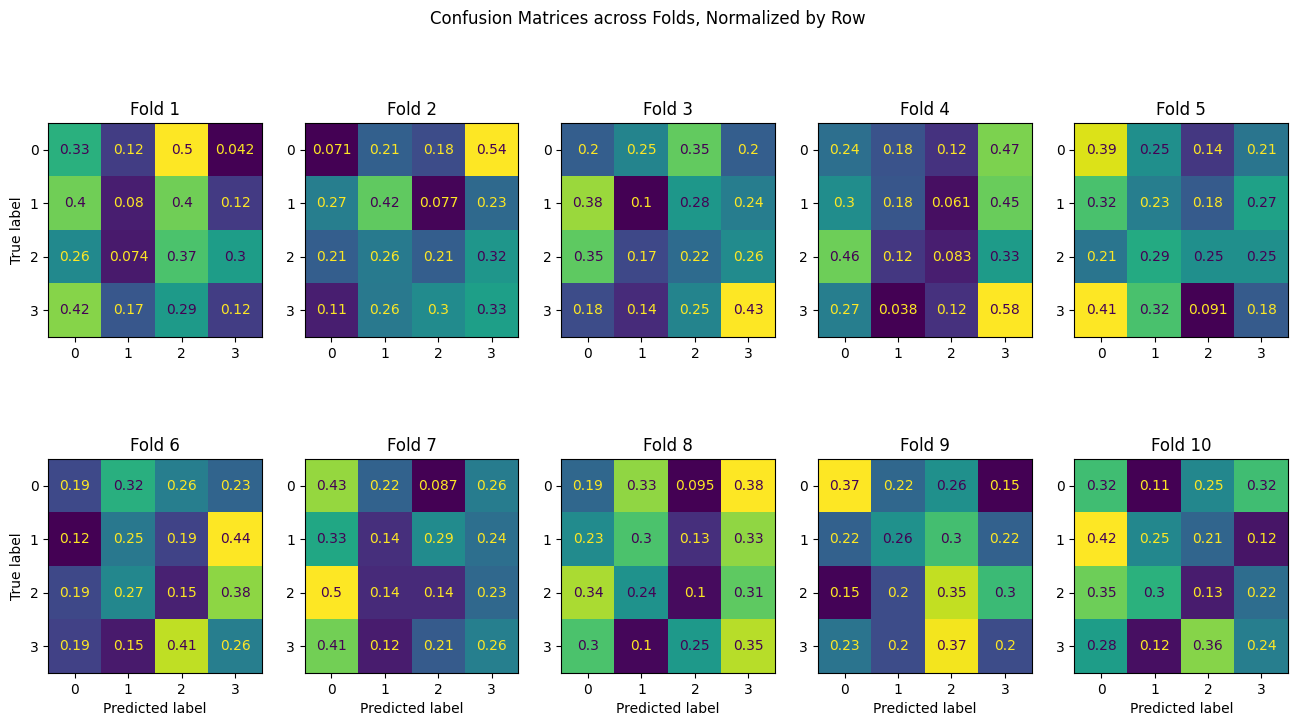

In [11]:
fig,axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.ravel()

for k in range(1,11):
    y_pred = oof_and_val[f"fold_{k}"]["y_pred"].flatten()
    y_val  = oof_and_val[f"fold_{k}"]["y_val"]
    cmatrix = confusion_matrix(y_val, y_pred, normalize="true")
    
    plt.subplot(2, 5, k)
    disp = ConfusionMatrixDisplay(cmatrix)
    disp.plot(ax=plt.gca(), cmap='viridis', colorbar=False)
    
    plt.title(f"Fold {k}")
    if (k-1)%5 != 0:
       plt.ylabel("")
    if(k-1) < 5:
        plt.xlabel("")

plt.suptitle("Confusion Matrices across Folds, Normalized by Row")
plt.show()

In [12]:
catboost_ohe_pipe = make_pipeline(OneHotEncoder(),
                                  CatBoostClassifier(**catboost_params1))
accuracy_scores, oof_and_val = cv_validate(X, y, catboost_ohe_pipe)

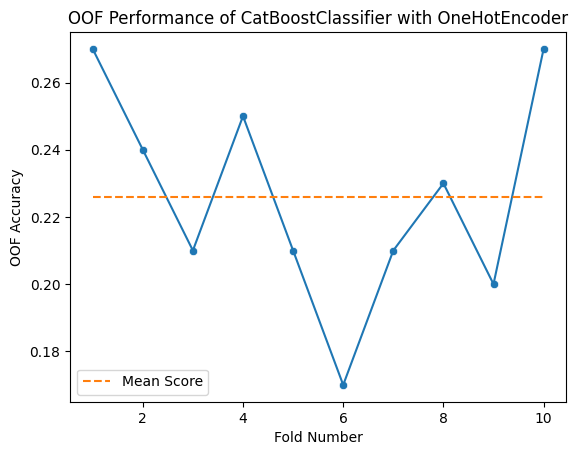

In [13]:
sea.scatterplot(x=np.arange(1, 11),
                y=accuracy_scores)
sea.lineplot(x=np.arange(1, 11),
             y=accuracy_scores)
sea.lineplot(x=np.arange(1, 11),
             y=np.mean(accuracy_scores),
             linestyle="dashed",
             label="Mean Score")

plt.xlabel("Fold Number")
plt.ylabel("OOF Accuracy")
plt.title("OOF Performance of CatBoostClassifier with OneHotEncoder")
plt.show()

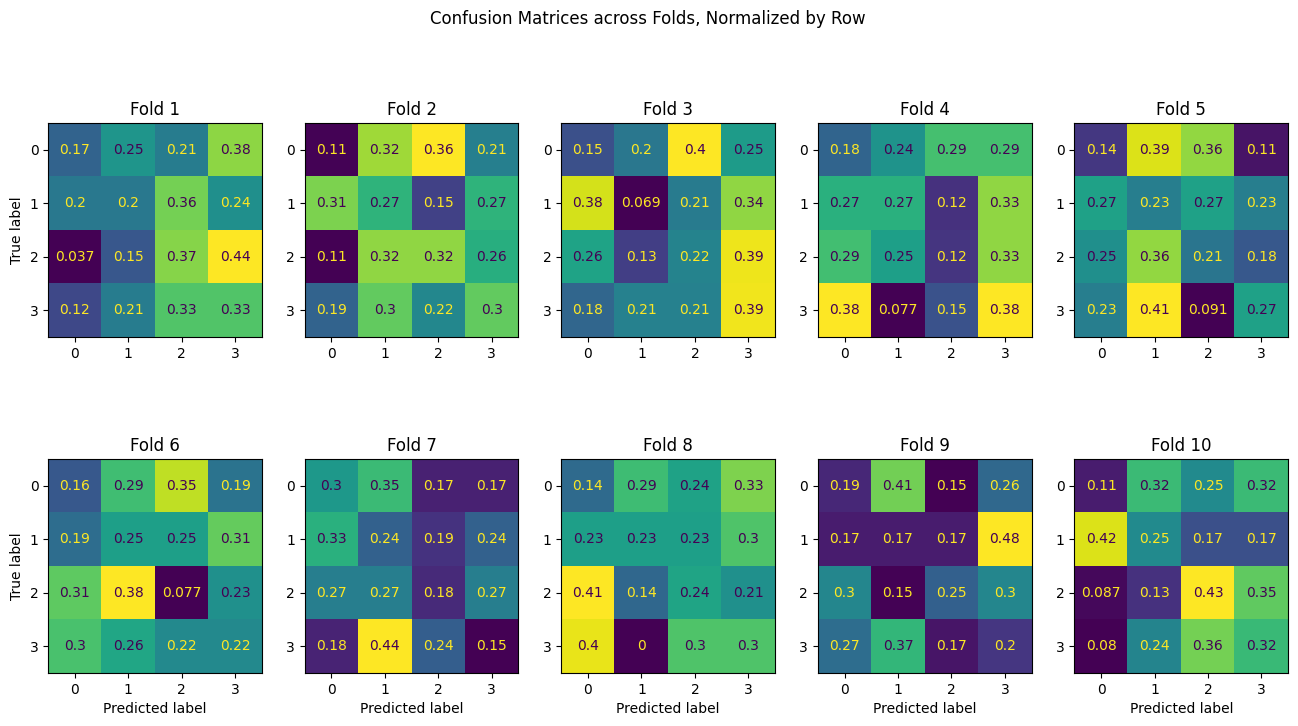

In [14]:
fig,axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.ravel()

for k in range(1,11):
    y_pred = oof_and_val[f"fold_{k}"]["y_pred"].flatten()
    y_val  = oof_and_val[f"fold_{k}"]["y_val"]
    cmatrix = confusion_matrix(y_val, y_pred, normalize="true")
    
    plt.subplot(2, 5, k)
    disp = ConfusionMatrixDisplay(cmatrix)
    disp.plot(ax=plt.gca(), cmap='viridis', colorbar=False)
    
    plt.title(f"Fold {k}")
    if (k-1)%5 != 0:
       plt.ylabel("")
    if(k-1) < 5:
        plt.xlabel("")

plt.suptitle("Confusion Matrices across Folds, Normalized by Row")
plt.show()

# LGBMClassifier

### 1. OneHotEncoder results in higher mean CV score
### 2. Recall scores are consistently low for all classes (around 0.20)
### 3. Classes cannot be distinctly discriminated by the model, observed from confusion matrices in how no particular classes' recall scores are consistently high
### 4. Highest Mean OOF accuracy score is about 0.25

In [15]:
### Using catboost encoding
lgbm_params1 = {"n_estimators":250,
                "learning_rate":.045,
                "max_depth":7,
                "objective":"multiclass",
                "random_state":SEED,
                "n_jobs":-1,
                "verbose":-1
               }

lgbm_cbe_pipe = make_pipeline(CatBoostEncoder(),
                              LGBMClassifier(**lgbm_params1)
                             )

accuracy_scores, oof_and_val = cv_validate(X, y, lgbm_cbe_pipe)

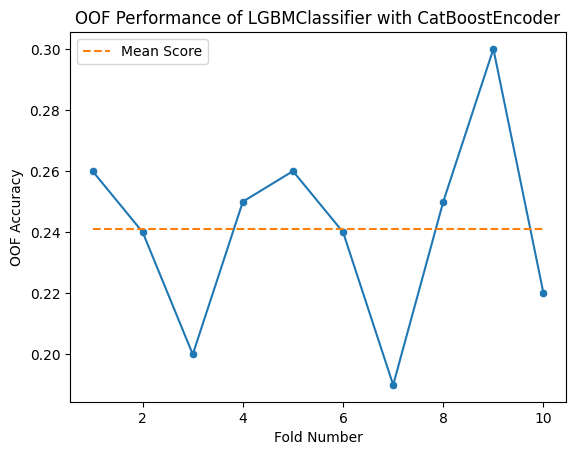

In [16]:
sea.scatterplot(x=np.arange(1, 11),
                y=accuracy_scores)
sea.lineplot(x=np.arange(1, 11),
             y=accuracy_scores)
sea.lineplot(x=np.arange(1, 11),
             y=np.mean(accuracy_scores),
             linestyle="dashed",
             label="Mean Score")

plt.xlabel("Fold Number")
plt.ylabel("OOF Accuracy")
plt.title("OOF Performance of LGBMClassifier with CatBoostEncoder")
plt.show()

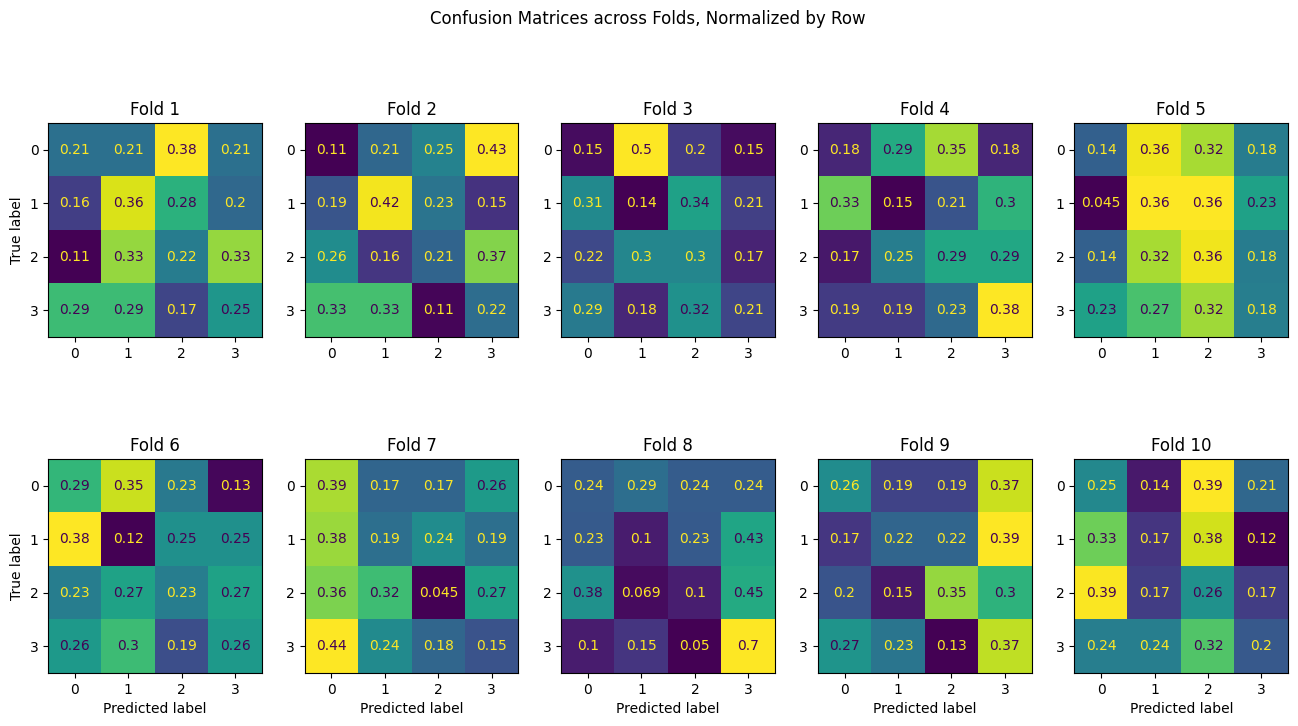

In [17]:
fig,axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.ravel()

for k in range(1,11):
    y_pred = oof_and_val[f"fold_{k}"]["y_pred"].flatten()
    y_val  = oof_and_val[f"fold_{k}"]["y_val"]
    cmatrix = confusion_matrix(y_val, y_pred, normalize="true")
    
    plt.subplot(2, 5, k)
    disp = ConfusionMatrixDisplay(cmatrix)
    disp.plot(ax=plt.gca(), cmap='viridis', colorbar=False)
    
    plt.title(f"Fold {k}")
    if (k-1)%5 != 0:
       plt.ylabel("")
    if(k-1) < 5:
        plt.xlabel("")

plt.suptitle("Confusion Matrices across Folds, Normalized by Row")
plt.show()

In [18]:
lgbm_ohe_pipe = make_pipeline(OneHotEncoder(),
                              LGBMClassifier(**lgbm_params1)
                             )

accuracy_scores, oof_and_val = cv_validate(X, y, lgbm_ohe_pipe)

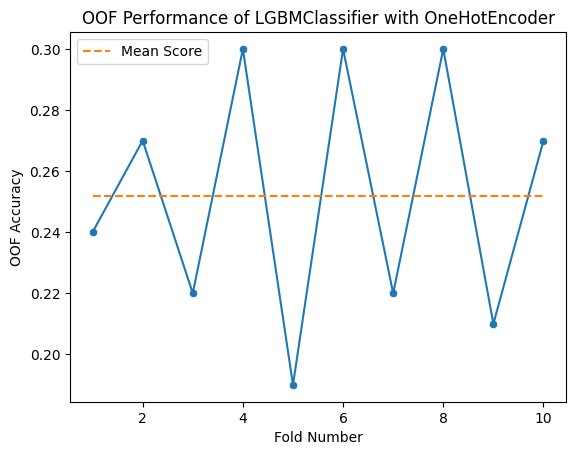

In [19]:
sea.scatterplot(x=np.arange(1, 11),
                y=accuracy_scores)
sea.lineplot(x=np.arange(1, 11),
             y=accuracy_scores)
sea.lineplot(x=np.arange(1, 11),
             y=np.mean(accuracy_scores),
             linestyle="dashed",
             label="Mean Score")

plt.xlabel("Fold Number")
plt.ylabel("OOF Accuracy")
plt.title("OOF Performance of LGBMClassifier with OneHotEncoder")
plt.show()

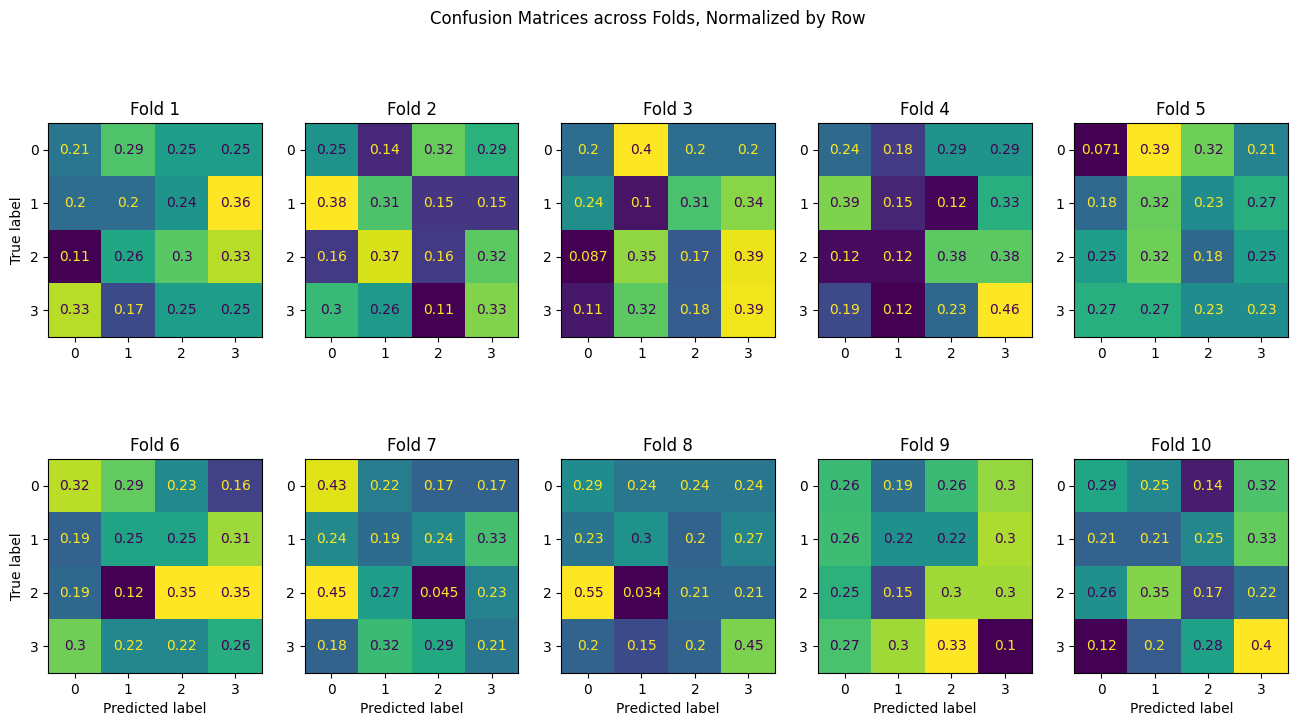

In [20]:
fig,axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.ravel()

for k in range(1,11):
    y_pred = oof_and_val[f"fold_{k}"]["y_pred"].flatten()
    y_val  = oof_and_val[f"fold_{k}"]["y_val"]
    cmatrix = confusion_matrix(y_val, y_pred, normalize="true")
    
    plt.subplot(2, 5, k)
    disp = ConfusionMatrixDisplay(cmatrix)
    disp.plot(ax=plt.gca(), cmap='viridis', colorbar=False)
    
    plt.title(f"Fold {k}")
    if (k-1)%5 != 0:
       plt.ylabel("")
    if(k-1) < 5:
        plt.xlabel("")

plt.suptitle("Confusion Matrices across Folds, Normalized by Row")
plt.show()

# Optimizing Models

In [21]:
def catboost_objective(trial):
    params = {
        "n_estimators" : trial.suggest_int("n_estimators", 100, 500, step=100),
        "learning_rate": trial.suggest_float("learning_rate", .05, .2, log=True),
        "depth" : trial.suggest_int("depth", 3, 6),
        "reg_lambda": trial.suggest_float("reg_lamdba", .001, 5.0, log=True),
        "bagging_temperature" : trial.suggest_float("bagging_temperature", .5, 1.0, log=True),
        "rsm" : trial.suggest_float("rsm", .5, 1.0, step=.1)    
        }
    params["thread_count"] = -1
    params["verbose"] = 0
    params["loss_function"] = "MultiClass"
    params["random_state"] = SEED
    params["cat_features"] = cat_features

    catboost = CatBoostClassifier(**params)
    return np.mean(cv_validate(X, y, catboost, False, n_splits=5))
    
# study = optuna.create_study(direction="maximize")
# study.optimize(catboost_objective, n_trials=100)

In [22]:
def lgbm_objective(trial):
    params = {
        "n_estimators" : trial.suggest_int("n_estimators", 100, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", .01, .2, log=True),
        "depth" : trial.suggest_int("depth", 3, 12, step=2),
        "num_leaves" : trial.suggest_int("num_leaves", 2**5, 2**10),
        "reg_lambda": trial.suggest_float("reg_lamdba", .001, 10.0, log=True),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", .5, 1.0, step=.1) ,
        "min_split_gain" : trial.suggest_float("min_split_gain", .003, 10, log=True)
        }
    params["n_jobs"] = -1
    params["verbose"] = -1
    params["objective"] = "multiclass"
    params["random_state"] = SEED

    lgbm_pipe = make_pipeline(
        OneHotEncoder(), 
        LGBMClassifier(**params)
    )
    return np.mean(cv_validate(X, y, lgbm_pipe, False))
    
# study = optuna.create_study(direction="maximize")
# study.optimize(lgbm_objective, n_trials=100)

In [23]:
## Mean accuracy of 0.254 across 5 folds
catboost_params = {
    'n_estimators': 200,
    'learning_rate': 0.1942609171813709,
    'depth': 3,
    'reg_lambda': 0.6492829922649704,
    'bagging_temperature': 0.8452088492054287,
    'rsm': 0.6
}
catboost_params["thread_count"] = -1
catboost_params["verbose"] = 0
catboost_params["loss_function"] = "MultiClass"
catboost_params["random_state"] = SEED
catboost_params["cat_features"] = cat_features

catboost = CatBoostClassifier(**catboost_params)
cat_accuracy_scores, cat_oof_and_val = cv_validate(X, y, catboost)

In [24]:
## Mean accuracy of 0.263 across 10 folds
lgbm_params = {
    'n_estimators': 700,
    'learning_rate': 0.1069770076397866,
    'depth': 9,
    'num_leaves': 433,
    'reg_lamdba': 0.7199741339821919,
    'colsample_bytree': 0.9,
    'min_split_gain': 9.790006801448392
}
lgbm_params["n_jobs"] = -1
lgbm_params["verbose"] = -1
lgbm_params["objective"] = "multiclass"
lgbm_params["random_state"] = SEED

lgbm_ohe_pipe = make_pipeline(
    OneHotEncoder(),
    LGBMClassifier(**lgbm_params)
)

lgbm_accuracy_scores, lgbm_oof_and_val = cv_validate(X, y, lgbm_ohe_pipe)

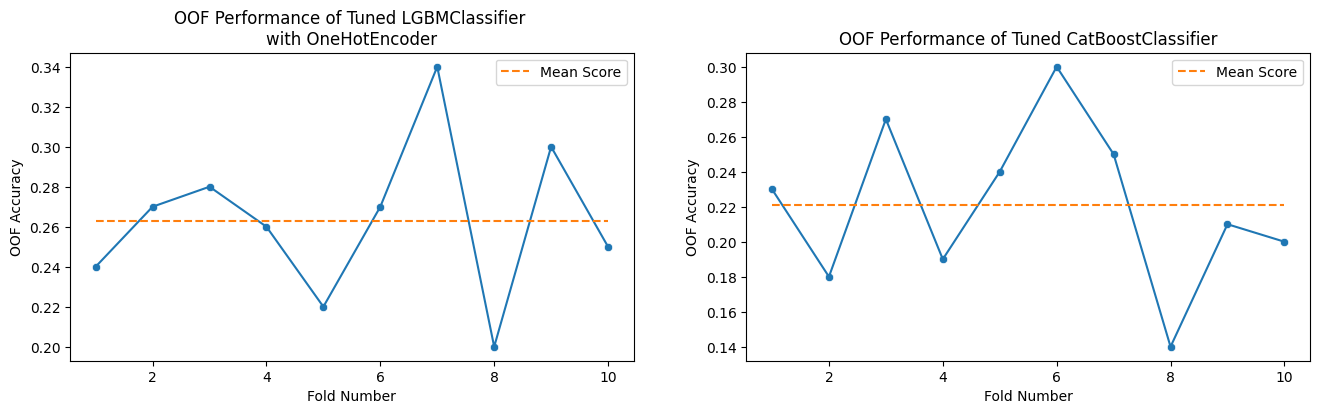

In [25]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sea.scatterplot(x=np.arange(1, 11),
                y=lgbm_accuracy_scores)
sea.lineplot(x=np.arange(1, 11),
             y=lgbm_accuracy_scores)
sea.lineplot(x=np.arange(1, 11),
             y=np.mean(lgbm_accuracy_scores),
             linestyle="dashed",
             label="Mean Score")

plt.xlabel("Fold Number")
plt.ylabel("OOF Accuracy")
plt.title("OOF Performance of Tuned LGBMClassifier \nwith OneHotEncoder")

plt.subplot(1, 2, 2)
sea.scatterplot(x=np.arange(1, 11),
                y=cat_accuracy_scores)
sea.lineplot(x=np.arange(1, 11),
             y=cat_accuracy_scores)
sea.lineplot(x=np.arange(1, 11),
             y=np.mean(cat_accuracy_scores),
             linestyle="dashed",
             label="Mean Score")

plt.xlabel("Fold Number")
plt.ylabel("OOF Accuracy")
plt.title("OOF Performance of Tuned CatBoostClassifier")
plt.show()

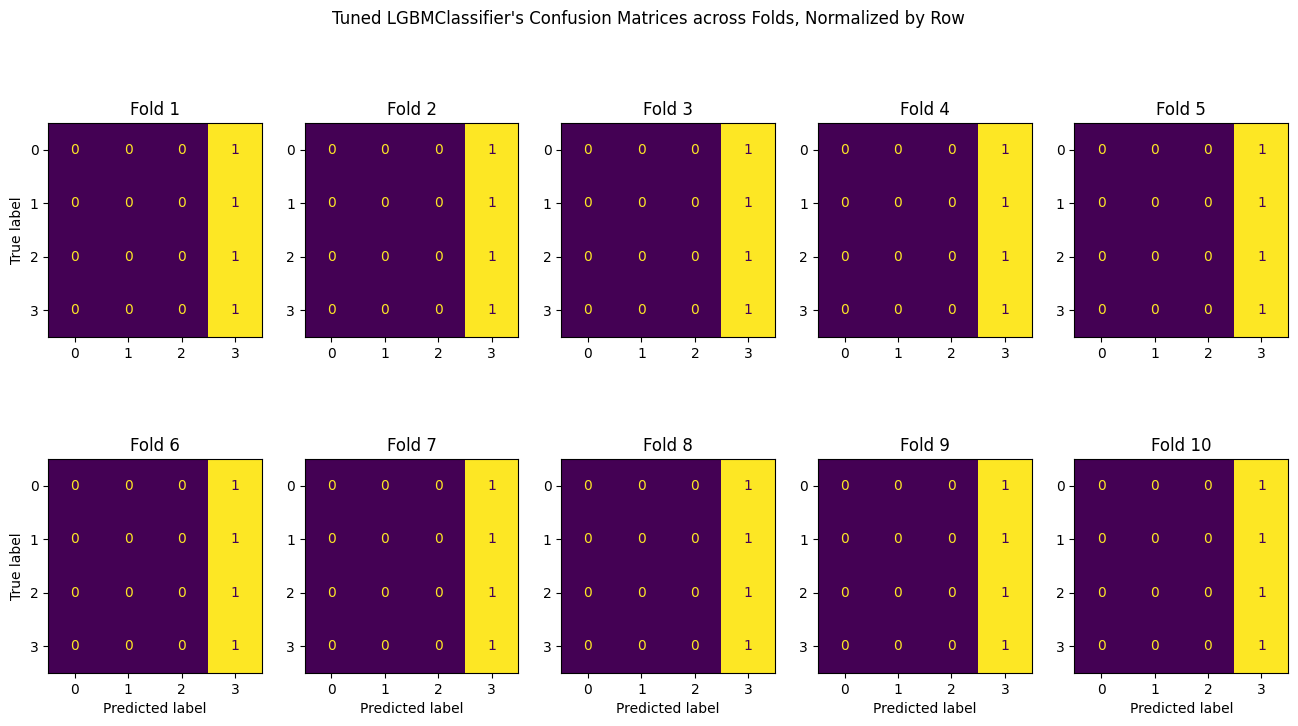

In [26]:
fig,axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.ravel()

for k in range(1,11):
    y_pred = lgbm_oof_and_val[f"fold_{k}"]["y_pred"].flatten()
    y_val  = lgbm_oof_and_val[f"fold_{k}"]["y_val"]
    cmatrix = confusion_matrix(y_val, y_pred, normalize="true")
    
    plt.subplot(2, 5, k)
    disp = ConfusionMatrixDisplay(cmatrix)
    disp.plot(ax=plt.gca(), cmap='viridis', colorbar=False)
    
    plt.title(f"Fold {k}")
    if (k-1)%5 != 0:
       plt.ylabel("")
    if(k-1) < 5:
        plt.xlabel("")

plt.suptitle("Tuned LGBMClassifier's Confusion Matrices across Folds, Normalized by Row")
plt.show()

#### Interestingly, the tuned LGBMClassifier has learned to classify all samples with label 3; this is not learning at all but naively guessing!

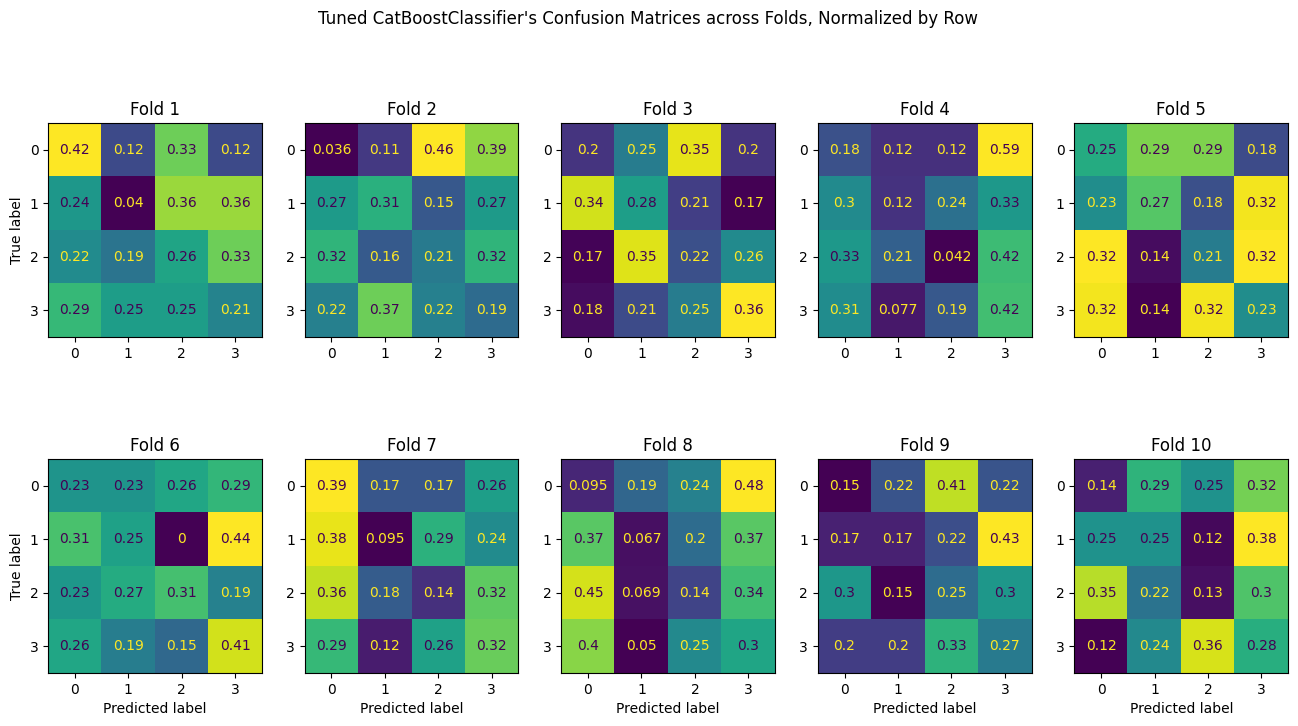

In [27]:
fig,axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.ravel()

for k in range(1,11):
    y_pred = cat_oof_and_val[f"fold_{k}"]["y_pred"].flatten()
    y_val  = cat_oof_and_val[f"fold_{k}"]["y_val"]
    cmatrix = confusion_matrix(y_val, y_pred, normalize="true")
    
    plt.subplot(2, 5, k)
    disp = ConfusionMatrixDisplay(cmatrix)
    disp.plot(ax=plt.gca(), cmap='viridis', colorbar=False)
    
    plt.title(f"Fold {k}")
    if (k-1)%5 != 0:
       plt.ylabel("")
    if(k-1) < 5:
        plt.xlabel("")

plt.suptitle("Tuned CatBoostClassifier's Confusion Matrices across Folds, Normalized by Row")
plt.show()

# Conclusion
### From the synthetic nature of the data and the lack of relation between predictors, it is impossible to predict classes with deliberate certainty. The best performance may be achieved by naively predicting the particular class with the highest proportion, which was what the tuned LGBMClassifier did; in fact, the proportion of class 3 is 0.263, matching exactly with the mean accuracy score of the tuned LGBMClassifier. 